In [ ]:
!pip install gcsfs

In [ ]:
!pip install pandas openpyxl emoji transformers torch datasets scikit-learn fsspec==2025.3.0 gcsfs==2025.3.0

INFO: pip is looking at multiple versions of datasets to determine which version is compatible with other requirements. This could take a while.
INFO: pip is still looking at multiple versions of datasets to determine which version is compatible with other requirements. This could take a while.
INFO: This is taking longer than usual. You might need to provide the dependency resolver with stricter constraints to reduce runtime. See https://pip.pypa.io/warnings/backtracking for guidance. If you want to abort this run, press Ctrl + C.
INFO: pip is looking at multiple versions of multiprocess to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.3/519.3 kB 13.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 9.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.4/135.4 kB 10.0 MB/s eta 0:00:00
  Attempting uninstall: dill
    Found existing installation: dill 0.3.

In [ ]:
#one
# Install required libraries
#!pip install pandas openpyxl emoji transformers torch datasets scikit-learn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 590.6/590.6 kB 19.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 37.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 28.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 17.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 21.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 487.4/487.4 kB 24.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
#two
!git clone https://github.com/SenticNet/stress-detection

Cloning into 'stress-detection'...
remote: Enumerating objects: 22, done.
remote: Counting objects: 100% (22/22), done.
remote: Compressing objects: 100% (21/21), done.
remote: Total 22 (delta 7), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (22/22), 2.88 MiB | 5.80 MiB/s, done.
Resolving deltas: 100% (7/7), done.


In [ ]:
#three
import os
os.environ["WANDB_DISABLED"] = "true"

In [ ]:
#BERT on Reddit_Title.xlsx
import pandas as pd
import re
import emoji
import torch
from transformers import AutoModelForSequenceClassification, AutoTokenizer, Trainer, TrainingArguments
from datasets import Dataset
from sklearn.metrics import accuracy_score, f1_score


# Load datasets
df_title = pd.read_excel("/content/stress-detection/Reddit_Title.xlsx")
df_combi = pd.read_excel("/content/stress-detection/Reddit_Combi.xlsx")

# Preprocessing function
def preprocess_text(text):
    if isinstance(text, str):
        text = emoji.demojize(text)  # Convert emojis to text
        text = text.lower()  # Convert to lowercase
        text = re.sub(r"http\S+|www\S+", "", text)  # Remove URLs
        text = re.sub(r"[^a-zA-Z\s]", "", text)  # Remove special characters
        text = text.strip()  # Remove extra spaces
    return text

# Apply preprocessing
df_title["text"] = df_title["title"].apply(preprocess_text)
df_combi["text"] = df_combi["Body_Title"].apply(preprocess_text)

# Rename labels (assuming dataset has "label" column where 1 = Stress, 0 = No Stress)
df_title = df_title.rename(columns={"label": "labels"})
df_combi = df_combi.rename(columns={"label": "labels"})

# Select PLM model: Choose "bert-base-uncased", "distilbert-base-uncased", or "roberta-base"
MODEL_NAME = "bert-base-uncased"

# Load tokenizer and model
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
model = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=2)

# Tokenize dataset
def tokenize_function(examples):
    return tokenizer(examples["text"], padding="max_length", truncation=True)

# Convert Pandas to Hugging Face Dataset
dataset_title = Dataset.from_pandas(df_title[["text", "labels"]])
dataset_combi = Dataset.from_pandas(df_combi[["text", "labels"]])

# Tokenize data
dataset_title = dataset_title.map(tokenize_function, batched=True)
dataset_combi = dataset_combi.map(tokenize_function, batched=True)

# Split into train & test sets (80% train, 20% test)
dataset_title = dataset_title.train_test_split(test_size=0.2)
dataset_combi = dataset_combi.train_test_split(test_size=0.2)

# Define training arguments
training_args = TrainingArguments(
    output_dir="./results",
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=3,
    weight_decay=0.01,
)

# Define evaluation function
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = predictions.argmax(axis=1)
    acc = accuracy_score(labels, predictions)
    f1 = f1_score(labels, predictions)
    return {"accuracy": acc, "f1": f1}

# Trainer setup
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=dataset_title["train"],
    eval_dataset=dataset_title["test"],
    compute_metrics=compute_metrics,
)

# Train the model
trainer.train()

# Evaluate the model
eval_results = trainer.evaluate()
print("Evaluation Results:", eval_results)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/5556 [00:00<?, ? examples/s]

Map:   0%|          | 0/3123 [00:00<?, ? examples/s]

Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.192400,0.146177,0.966727,0.966757
2,0.072700,0.176763,0.966727,0.967228
3,0.037100,0.208480,0.964029,0.964413


Evaluation Results: {'eval_loss': 0.20847982168197632, 'eval_accuracy': 0.9640287769784173, 'eval_f1': 0.9644128113879004, 'eval_runtime': 31.0707, 'eval_samples_per_second': 35.789, 'eval_steps_per_second': 4.474, 'epoch': 3.0}


In [ ]:
#four
#RoBERT on Reddit_Title.xlsx
import pandas as pd
import re
import emoji
import torch
from transformers import AutoModelForSequenceClassification, AutoTokenizer, Trainer, TrainingArguments
from datasets import Dataset
from sklearn.metrics import accuracy_score, f1_score


# Load datasets
df_title = pd.read_excel("/content/stress-detection/Reddit_Title.xlsx")
df_combi = pd.read_excel("/content/stress-detection/Reddit_Combi.xlsx")

# Preprocessing function
def preprocess_text(text):
    if isinstance(text, str):
        text = emoji.demojize(text)  # Convert emojis to text
        text = text.lower()  # Convert to lowercase
        text = re.sub(r"http\S+|www\S+", "", text)  # Remove URLs
        text = re.sub(r"[^a-zA-Z\s]", "", text)  # Remove special characters
        text = text.strip()  # Remove extra spaces
    return text

# Apply preprocessing
df_title["text"] = df_title["title"].apply(preprocess_text)
df_combi["text"] = df_combi["Body_Title"].apply(preprocess_text)

# Rename labels (assuming dataset has "label" column where 1 = Stress, 0 = No Stress)
df_title = df_title.rename(columns={"label": "labels"})
df_combi = df_combi.rename(columns={"label": "labels"})

# Select PLM model: Choose "bert-base-uncased", "distilbert-base-uncased", or "roberta-base"
MODEL_NAME = "roberta-base"

# Load tokenizer and model
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
model = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=2)

# Tokenize dataset
def tokenize_function(examples):
    return tokenizer(examples["text"], padding="max_length", truncation=True)

# Convert Pandas to Hugging Face Dataset
dataset_title = Dataset.from_pandas(df_title[["text", "labels"]])
dataset_combi = Dataset.from_pandas(df_combi[["text", "labels"]])

# Tokenize data
dataset_title = dataset_title.map(tokenize_function, batched=True)
dataset_combi = dataset_combi.map(tokenize_function, batched=True)

# Split into train & test sets (80% train, 20% test)
dataset_title = dataset_title.train_test_split(test_size=0.2)
dataset_combi = dataset_combi.train_test_split(test_size=0.2)

# Define training arguments
training_args = TrainingArguments(
    output_dir="./results",
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=3,
    weight_decay=0.01,
)

# Define evaluation function
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = predictions.argmax(axis=1)
    acc = accuracy_score(labels, predictions)
    f1 = f1_score(labels, predictions)
    return {"accuracy": acc, "f1": f1}

# Trainer setup
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=dataset_title["train"],
    eval_dataset=dataset_title["test"],
    compute_metrics=compute_metrics,
)

# Train the model
trainer.train()

# Evaluate the model
eval_results = trainer.evaluate()
print("Evaluation Results:", eval_results)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/5556 [00:00<?, ? examples/s]

Map:   0%|          | 0/3123 [00:00<?, ? examples/s]

Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.230300,0.205482,0.949640,0.954619
2,0.121000,0.166448,0.969424,0.971380
3,0.042800,0.193625,0.969424,0.971332


Evaluation Results: {'eval_loss': 0.19362470507621765, 'eval_accuracy': 0.9694244604316546, 'eval_f1': 0.9713322091062394, 'eval_runtime': 29.146, 'eval_samples_per_second': 38.153, 'eval_steps_per_second': 4.769, 'epoch': 3.0}


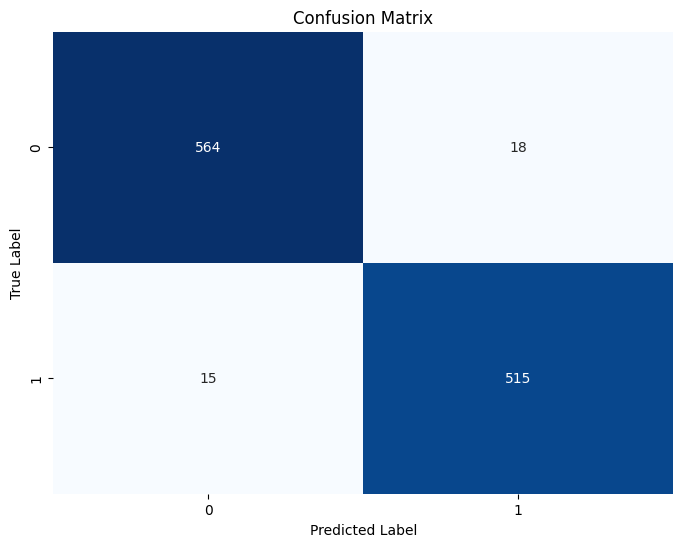

In [ ]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Get predictions
predictions = trainer.predict(dataset_title['test'])
y_pred = np.argmax(predictions.predictions, axis=1)
y_true = predictions.label_ids

# Generate confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()


In [ ]:
#five
!pip install joblib
import joblib

# Save model and tokenizer
MODEL_SAVE_PATH = "./roberta_stress_model.pkl"
TOKENIZER_SAVE_PATH = "./roberta_tokenizer.pkl"

joblib.dump(model, MODEL_SAVE_PATH)
joblib.dump(tokenizer, TOKENIZER_SAVE_PATH)

print("Model and tokenizer saved successfully!")

Model and tokenizer saved successfully!


In [ ]:
#six
!pip install streamlit==1.41.1 pyngrok

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.3/44.3 kB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.1/9.1 MB 54.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 75.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.1/79.1 kB 7.1 MB/s eta 0:00:00


In [ ]:
'''import streamlit as st
import torch
import joblib
from transformers import AutoTokenizer
import re
import emoji
import time

# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load model and tokenizer (Ensure correct path in Google Drive or upload manually)
MODEL_PATH = "./roberta_stress_model.pkl"
TOKENIZER_PATH = "./roberta_tokenizer.pkl"

try:
    model = joblib.load(MODEL_PATH).to(device)
    tokenizer = joblib.load(TOKENIZER_PATH)
except:
    st.error("Model or tokenizer not found! Please upload them.")
    st.stop()

# Preprocessing function
def preprocess_text(text):
    text = emoji.demojize(text)
    text = text.lower()
    text = re.sub(r"http\S+|www\S+", "", text)
    text = re.sub(r"[^a-zA-Z\s]", "", text)
    text = text.strip()
    return text

# Prediction function
def predict_stress(text):
    processed_text = preprocess_text(text)
    inputs = tokenizer(processed_text, return_tensors="pt", padding=True, truncation=True).to(device)
    with torch.no_grad():
        outputs = model(**inputs)
    probabilities = torch.nn.functional.softmax(outputs.logits, dim=-1)
    stress_score = probabilities[0][1].item()
    return stress_score

# Streamlit UI
st.set_page_config(page_title="Stress Detection", layout="centered")
st.markdown("""
    <h1 style='text-align: center; color: #ff4b4b;'>🧠 Stress Detection from Reddit Titles</h1>
    <p style='text-align: center;'>Enter a Reddit post title to check if it indicates stress.</p>
    <hr>
""", unsafe_allow_html=True)

user_input = st.text_area("Enter Reddit Title:", "", help="Type a Reddit post title here...")

if st.button("Analyze", use_container_width=True):
    if user_input:
        with st.spinner("Analyzing..."):
            time.sleep(1)  # Simulating processing time
            stress_score = predict_stress(user_input)
            label = "😨 Stressed" if stress_score > 0.5 else "😊 Not Stressed"

            st.subheader(f"Prediction: {label}")
            st.progress(stress_score)
            st.write(f"Confidence Score: {stress_score:.4f}")
    else:
        st.warning("⚠️ Please enter a Reddit title.")

st.markdown("<p style='text-align: center; color: gray;'>Powered by <b>RoBERTa</b> for stress detection.</p>", unsafe_allow_html=True)
'''

In [ ]:
#seven
#replace the [authtoken]
!ngrok config add-authtoken [authtoken]

Authtoken saved to configuration file: /root/.config/ngrok/ngrok.yml


In [ ]:
#eight
from pyngrok import ngrok

# Define the new port for the Streamlit app
new_port = 8508

# Run the Streamlit app on the new port
!streamlit run appr.py --server.port {new_port} &>/content/logs.txt &

# Ensure all previous tunnels are closed before opening a new one
ngrok.kill()

# Start a new ngrok tunnel on the new port
public_url = ngrok.connect(new_port, "http")
print(f"Public URL: {public_url}")

Public URL: NgrokTunnel: "https://79ec-34-125-11-73.ngrok-free.app" -> "http://localhost:8508"


In [ ]:
# Ensure all previous tunnels are closed before opening a new one
ngrok.kill()

In [ ]:
import torch
import re
import emoji

# Function to preprocess text (same as used during training)
def preprocess_text(text):
    text = emoji.demojize(text)  # Convert emojis to text
    text = text.lower()
    text = re.sub(r"http\S+|www\S+", "", text)  # Remove URLs
    text = re.sub(r"[^a-zA-Z\s]", "", text)  # Remove special characters
    text = text.strip()
    return text

# Function to predict stress from user input
def predict_stress(text):
    text = preprocess_text(text)

    # Tokenize input text
    inputs = tokenizer(text, padding="max_length", truncation=True, max_length=128, return_tensors="pt")

    # Move input to GPU if available
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    inputs = {key: val.to(device) for key, val in inputs.items()}

    # Get model prediction
    with torch.no_grad():
        outputs = model(**inputs)

    logits = outputs.logits
    prediction = torch.argmax(logits, dim=1).item()

    # Return result
    return "Stress Detected 😟" if prediction == 1 else "No Stress Detected 😊"

# Continuous loop to take input from the user
while True:
    user_input = input("Enter a sentence (or type 'exit' to quit): ")
    if user_input.lower() == 'exit':
        print("Exiting stress detection system.")
        break
    result = predict_stress(user_input)
    print(f"Prediction: {result}\n")


Enter a sentence (or type 'exit' to quit): I feel like to cry
Prediction: Stress Detected 😟

Enter a sentence (or type 'exit' to quit): I am soo happy today
Prediction: No Stress Detected 😊

Enter a sentence (or type 'exit' to quit): She said that her mother had beaten her
Prediction: Stress Detected 😟

Enter a sentence (or type 'exit' to quit): He is soo surprised to receive a gift
Prediction: No Stress Detected 😊

Enter a sentence (or type 'exit' to quit): There is piles of work pending and I don't know what to do
Prediction: Stress Detected 😟

Enter a sentence (or type 'exit' to quit): The product I received was really nice and worthy
Prediction: No Stress Detected 😊

Enter a sentence (or type 'exit' to quit): The product I received was costly and now I feel regret
Prediction: Stress Detected 😟

Enter a sentence (or type 'exit' to quit): I passed in my exam
Prediction: No Stress Detected 😊

Enter a sentence (or type 'exit' to quit): He failed in his final exam
Prediction: Stress Det

In [ ]:
#RoBERT on Reddit_Combi.xlsx
import pandas as pd
import re
import emoji
import torch
from transformers import AutoModelForSequenceClassification, AutoTokenizer, Trainer, TrainingArguments
from datasets import Dataset
from sklearn.metrics import accuracy_score, f1_score


# Load datasets
df_title = pd.read_excel("/content/stress-detection/Reddit_Title.xlsx")
df_combi = pd.read_excel("/content/stress-detection/Reddit_Combi.xlsx")

# Preprocessing function
def preprocess_text(text):
    if isinstance(text, str):
        text = emoji.demojize(text)  # Convert emojis to text
        text = text.lower()  # Convert to lowercase
        text = re.sub(r"http\S+|www\S+", "", text)  # Remove URLs
        text = re.sub(r"[^a-zA-Z\s]", "", text)  # Remove special characters
        text = text.strip()  # Remove extra spaces
    return text

# Apply preprocessing
df_title["text"] = df_title["title"].apply(preprocess_text)
df_combi["text"] = df_combi["Body_Title"].apply(preprocess_text)

# Rename labels (assuming dataset has "label" column where 1 = Stress, 0 = No Stress)
df_title = df_title.rename(columns={"label": "labels"})
df_combi = df_combi.rename(columns={"label": "labels"})

# Select PLM model: Choose "bert-base-uncased", "distilbert-base-uncased", or "roberta-base"
MODEL_NAME = "roberta-base"

# Load tokenizer and model
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
model = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=2)

# Tokenize dataset
def tokenize_function(examples):
    return tokenizer(examples["text"], padding="max_length", truncation=True)

# Convert Pandas to Hugging Face Dataset
dataset_title = Dataset.from_pandas(df_title[["text", "labels"]])
dataset_combi = Dataset.from_pandas(df_combi[["text", "labels"]])

# Tokenize data
dataset_title = dataset_title.map(tokenize_function, batched=True)
dataset_combi = dataset_combi.map(tokenize_function, batched=True)

# Split into train & test sets (80% train, 20% test)
dataset_title = dataset_title.train_test_split(test_size=0.2)
dataset_combi = dataset_combi.train_test_split(test_size=0.2)

# Define training arguments
training_args = TrainingArguments(
    output_dir="./results",
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=3,
    weight_decay=0.01,
)

# Define evaluation function
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = predictions.argmax(axis=1)
    acc = accuracy_score(labels, predictions)
    f1 = f1_score(labels, predictions)
    return {"accuracy": acc, "f1": f1}

# Trainer setup
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=dataset_combi["train"],
    eval_dataset=dataset_combi["test"],
    compute_metrics=compute_metrics,
)

# Train the model
trainer.train()

# Evaluate the model
eval_results = trainer.evaluate()
print("Evaluation Results:", eval_results)

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/5556 [00:00<?, ? examples/s]

Map:   0%|          | 0/3123 [00:00<?, ? examples/s]

Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,No log,0.317569,0.926400,0.957565
2,0.191500,0.233324,0.956800,0.975741


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,No log,0.317569,0.926400,0.957565
2,0.191500,0.233324,0.956800,0.975741
3,0.191500,0.277523,0.952000,0.972973


Evaluation Results: {'eval_loss': 0.27752313017845154, 'eval_accuracy': 0.952, 'eval_f1': 0.972972972972973, 'eval_runtime': 16.4669, 'eval_samples_per_second': 37.955, 'eval_steps_per_second': 4.797, 'epoch': 3.0}


In [ ]:
#distilbert on Reddit_Title.xlsx
import pandas as pd
import re
import emoji
import torch
from transformers import AutoModelForSequenceClassification, AutoTokenizer, Trainer, TrainingArguments
from datasets import Dataset
from sklearn.metrics import accuracy_score, f1_score


# Load datasets
df_title = pd.read_excel("/content/stress-detection/Reddit_Title.xlsx")
df_combi = pd.read_excel("/content/stress-detection/Reddit_Combi.xlsx")

# Preprocessing function
def preprocess_text(text):
    if isinstance(text, str):
        text = emoji.demojize(text)  # Convert emojis to text
        text = text.lower()  # Convert to lowercase
        text = re.sub(r"http\S+|www\S+", "", text)  # Remove URLs
        text = re.sub(r"[^a-zA-Z\s]", "", text)  # Remove special characters
        text = text.strip()  # Remove extra spaces
    return text

# Apply preprocessing
df_title["text"] = df_title["title"].apply(preprocess_text)
df_combi["text"] = df_combi["Body_Title"].apply(preprocess_text)

# Rename labels (assuming dataset has "label" column where 1 = Stress, 0 = No Stress)
df_title = df_title.rename(columns={"label": "labels"})
df_combi = df_combi.rename(columns={"label": "labels"})

# Select PLM model: Choose "bert-base-uncased", "distilbert-base-uncased", or "roberta-base"
MODEL_NAME = "distilbert-base-uncased"

# Load tokenizer and model
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
model = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=2)

# Tokenize dataset
def tokenize_function(examples):
    return tokenizer(examples["text"], padding="max_length", truncation=True)

# Convert Pandas to Hugging Face Dataset
dataset_title = Dataset.from_pandas(df_title[["text", "labels"]])
dataset_combi = Dataset.from_pandas(df_combi[["text", "labels"]])

# Tokenize data
dataset_title = dataset_title.map(tokenize_function, batched=True)
dataset_combi = dataset_combi.map(tokenize_function, batched=True)

# Split into train & test sets (80% train, 20% test)
dataset_title = dataset_title.train_test_split(test_size=0.2)
dataset_combi = dataset_combi.train_test_split(test_size=0.2)

# Define training arguments
training_args = TrainingArguments(
    output_dir="./results",
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=3,
    weight_decay=0.01,
)

# Define evaluation function
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = predictions.argmax(axis=1)
    acc = accuracy_score(labels, predictions)
    f1 = f1_score(labels, predictions)
    return {"accuracy": acc, "f1": f1}

# Trainer setup
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=dataset_title["train"],
    eval_dataset=dataset_title["test"],
    compute_metrics=compute_metrics,
)

# Train the model
trainer.train()

# Evaluate the model
eval_results = trainer.evaluate()
print("Evaluation Results:", eval_results)

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/5556 [00:00<?, ? examples/s]

Map:   0%|          | 0/3123 [00:00<?, ? examples/s]

Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.225600,0.153262,0.957734,0.957923
2,0.083800,0.130872,0.967626,0.968310


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.225600,0.153262,0.957734,0.957923
2,0.083800,0.130872,0.967626,0.968310
3,0.056900,0.161382,0.964029,0.964602


Evaluation Results: {'eval_loss': 0.16138210892677307, 'eval_accuracy': 0.9640287769784173, 'eval_f1': 0.9646017699115044, 'eval_runtime': 16.0301, 'eval_samples_per_second': 69.369, 'eval_steps_per_second': 8.671, 'epoch': 3.0}


In [ ]:
#distilbert on Reddit_Combi.xlsx
import pandas as pd
import re
import emoji
import torch
from transformers import AutoModelForSequenceClassification, AutoTokenizer, Trainer, TrainingArguments
from datasets import Dataset
from sklearn.metrics import accuracy_score, f1_score


# Load datasets
df_title = pd.read_excel("/content/stress-detection/Reddit_Title.xlsx")
df_combi = pd.read_excel("/content/stress-detection/Reddit_Combi.xlsx")

# Preprocessing function
def preprocess_text(text):
    if isinstance(text, str):
        text = emoji.demojize(text)  # Convert emojis to text
        text = text.lower()  # Convert to lowercase
        text = re.sub(r"http\S+|www\S+", "", text)  # Remove URLs
        text = re.sub(r"[^a-zA-Z\s]", "", text)  # Remove special characters
        text = text.strip()  # Remove extra spaces
    return text

# Apply preprocessing
df_title["text"] = df_title["title"].apply(preprocess_text)
df_combi["text"] = df_combi["Body_Title"].apply(preprocess_text)

# Rename labels (assuming dataset has "label" column where 1 = Stress, 0 = No Stress)
df_title = df_title.rename(columns={"label": "labels"})
df_combi = df_combi.rename(columns={"label": "labels"})

# Select PLM model: Choose "bert-base-uncased", "distilbert-base-uncased", or "roberta-base"
MODEL_NAME = "distilbert-base-uncased"

# Load tokenizer and model
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
model = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=2)

# Tokenize dataset
def tokenize_function(examples):
    return tokenizer(examples["text"], padding="max_length", truncation=True)

# Convert Pandas to Hugging Face Dataset
dataset_title = Dataset.from_pandas(df_title[["text", "labels"]])
dataset_combi = Dataset.from_pandas(df_combi[["text", "labels"]])

# Tokenize data
dataset_title = dataset_title.map(tokenize_function, batched=True)
dataset_combi = dataset_combi.map(tokenize_function, batched=True)

# Split into train & test sets (80% train, 20% test)
dataset_title = dataset_title.train_test_split(test_size=0.2)
dataset_combi = dataset_combi.train_test_split(test_size=0.2)

# Define training arguments
training_args = TrainingArguments(
    output_dir="./results",
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=3,
    weight_decay=0.01,
)

# Define evaluation function
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = predictions.argmax(axis=1)
    acc = accuracy_score(labels, predictions)
    f1 = f1_score(labels, predictions)
    return {"accuracy": acc, "f1": f1}

# Trainer setup
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=dataset_combi["train"],
    eval_dataset=dataset_combi["test"],
    compute_metrics=compute_metrics,
)

# Train the model
trainer.train()

# Evaluate the model
eval_results = trainer.evaluate()
print("Evaluation Results:", eval_results)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/5556 [00:00<?, ? examples/s]

Map:   0%|          | 0/3123 [00:00<?, ? examples/s]

Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,No log,0.186715,0.947200,0.970457
2,0.186900,0.239403,0.940800,0.966994
3,0.186900,0.238954,0.944000,0.968610


Evaluation Results: {'eval_loss': 0.23895439505577087, 'eval_accuracy': 0.944, 'eval_f1': 0.968609865470852, 'eval_runtime': 8.9778, 'eval_samples_per_second': 69.616, 'eval_steps_per_second': 8.799, 'epoch': 3.0}


In [ ]:
#EMOTION CLASSIFICATION

In [ ]:
import pandas as pd
import re
import emoji
import torch
from transformers import AutoModelForSequenceClassification, AutoTokenizer, Trainer, TrainingArguments
from datasets import Dataset
from sklearn.metrics import accuracy_score, f1_score

# Load dataset
df_combi = pd.read_excel("/content/stress-detection/Reddit_Combi.xlsx")

# Print column names to verify structure
print("Dataset Columns:", df_combi.columns)

# Preprocessing function
def preprocess_text(text):
    if isinstance(text, str):
        text = emoji.demojize(text)  # Convert emojis to text
        text = text.lower()  # Convert to lowercase
        text = re.sub(r"http\S+|www\S+", "", text)  # Remove URLs
        text = re.sub(r"[^a-zA-Z\s]", "", text)  # Remove special characters
        text = text.strip()  # Remove extra spaces
    return text

# Apply preprocessing
df_combi["text"] = df_combi["Body_Title"].apply(preprocess_text)

# Emotion label mapping (Modify as needed)
emotion_labels = {
    0: "joy",
    1: "sadness",
    2: "anger",
    3: "fear",
    4: "neutral"
}

# Check if "label" column exists
if "label" not in df_combi.columns:
    raise KeyError("The 'label' column is missing. Check your dataset structure.")

# Map labels to numerical values
df_combi["labels"] = df_combi["label"]

# Drop rows with missing labels
df_combi = df_combi.dropna(subset=["labels"]).reset_index(drop=True)

# Convert labels to integers
df_combi["labels"] = df_combi["labels"].astype(int)

# Select Pretrained Model
MODEL_NAME = "roberta-base"

# Load tokenizer and model
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
model = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=len(emotion_labels))

# Tokenization function
def tokenize_function(examples):
    return tokenizer(examples["text"], padding="max_length", truncation=True, max_length=128)

# Convert Pandas DataFrame to Hugging Face Dataset
dataset_combi = Dataset.from_pandas(df_combi[["text", "labels"]])

# Tokenize data
dataset_combi = dataset_combi.map(tokenize_function, batched=True)

# Remove the "text" column (but NOT "__index_level_0__" since it doesn't exist)
dataset_combi = dataset_combi.remove_columns(["text"])


# Split dataset into training (80%) and testing (20%)
dataset_combi = dataset_combi.train_test_split(test_size=0.2)

# Define training arguments
training_args = TrainingArguments(
    output_dir="./emotion_results",
    evaluation_strategy="epoch",
    save_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=4,
    weight_decay=0.01,
    logging_dir="./logs",
    save_total_limit=2,
)

# Define evaluation function
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = predictions.argmax(axis=1)
    acc = accuracy_score(labels, predictions)
    f1 = f1_score(labels, predictions, average="weighted")
    return {"accuracy": acc, "f1": f1}

# Trainer setup
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=dataset_combi["train"],
    eval_dataset=dataset_combi["test"],
    compute_metrics=compute_metrics,
)

# Train the model
trainer.train()

# Evaluate the model
eval_results = trainer.evaluate()
print("Evaluation Results:", eval_results)


Dataset Columns: Index(['title', 'body', 'Body_Title', 'label'], dtype='object')


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/3123 [00:00<?, ? examples/s]

/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,No log,0.253285,0.953600,0.951159
2,0.235900,0.254943,0.958400,0.956342
3,0.235900,0.263734,0.956800,0.955561
4,0.076200,0.279932,0.953600,0.952527


Evaluation Results: {'eval_loss': 0.27993160486221313, 'eval_accuracy': 0.9536, 'eval_f1': 0.9525269878508589, 'eval_runtime': 4.257, 'eval_samples_per_second': 146.815, 'eval_steps_per_second': 18.557, 'epoch': 4.0}


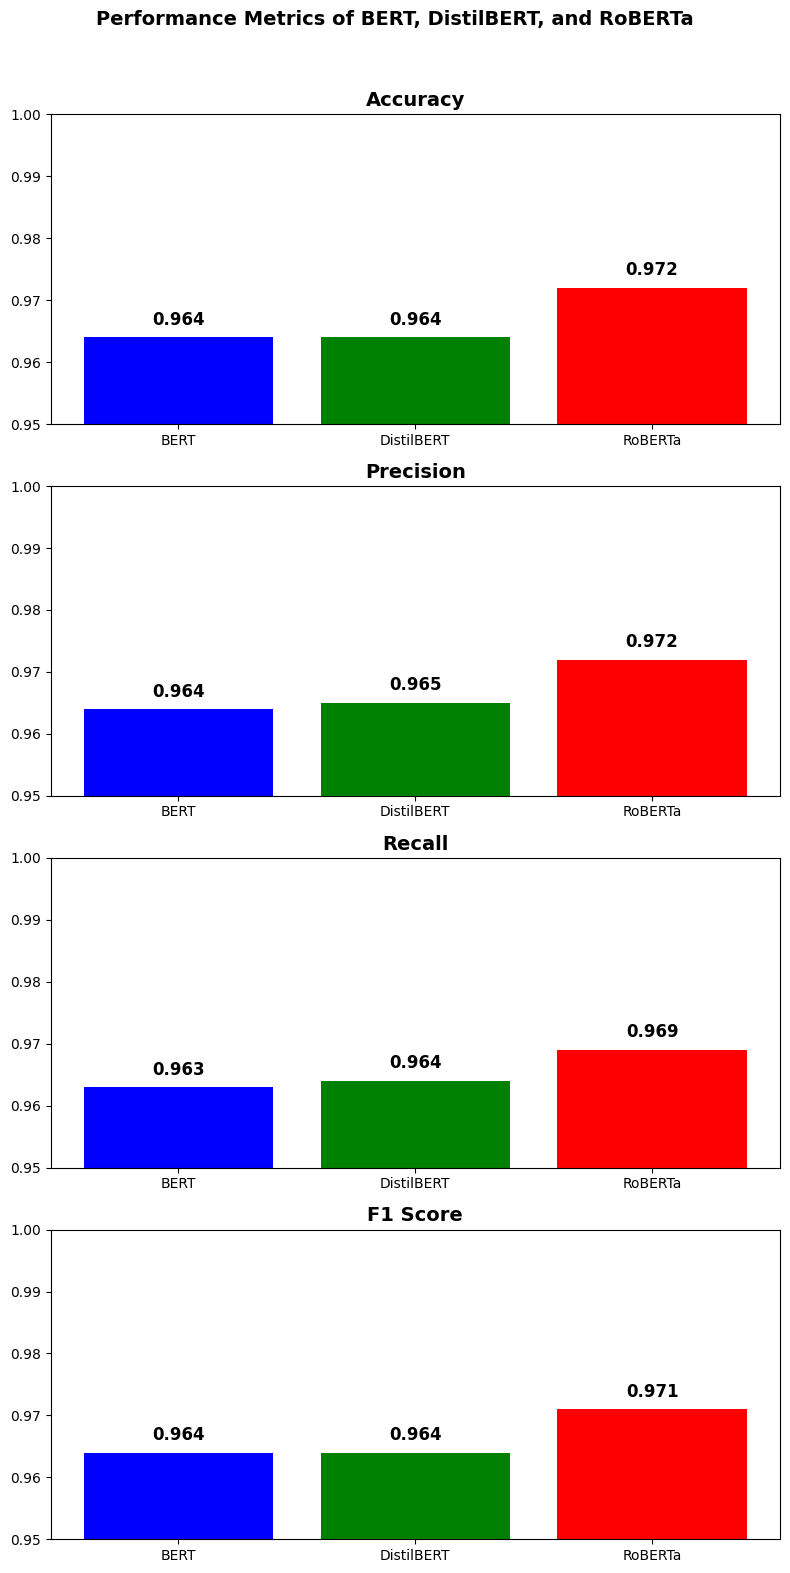

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Metrics
accuracy = [0.964, 0.964, 0.972]
precision = [0.964, 0.965, 0.972]
recall = [0.963, 0.964, 0.969]
f1_score = [0.964, 0.964, 0.971]

# Model names
models = ["BERT", "DistilBERT", "RoBERTa"]
metrics = [accuracy, precision, recall, f1_score]
titles = ["Accuracy", "Precision", "Recall", "F1 Score"]

# Bar width and color palette
bar_width = 0.5
colors = ["#4C72B0", "#55A868", "#C44E52"]

# Create figure
fig, axs = plt.subplots(4, 1, figsize=(8, 16))
plt.suptitle("Performance Metrics of BERT, DistilBERT, and RoBERTa", fontsize=14, fontweight='bold')

# Function to create bar plots with labels
def create_bar_plot(ax, data, title, color):
    sns.barplot(x=models, y=data, ax=ax, hue=models, palette=color, dodge=False)  # Updated line
    ax.set_title(title, fontsize=12, fontweight='bold')
    ax.set_ylim(0.95, 1.0)
    ax.grid(axis='y', linestyle="--", alpha=0.7)

    # (Rest of your function code remains the same)

    # Add value labels
    for i, v in enumerate(data):
        ax.text(i, v + 0.002, f"{v:.3f}", ha='center', fontsize=10, fontweight='bold')

for i, ax in enumerate(axs):
    ax.bar(models, metrics[i], color=['blue', 'green', 'red'])
    ax.set_ylim(0.95, 1.00)
    ax.set_title(titles[i], fontsize=14, fontweight='bold')

    # Display values on bars
    for j, value in enumerate(metrics[i]):
        ax.text(j, value + 0.002, f"{value:.3f}", ha='center', fontsize=12, fontweight='bold')

# Adjust layout and show plot
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()
